# Gender recognition by voice

Using acoustic features extracted from a voice recording to predict the gender of the speaker.

Recognizing the speaker's gender is useful in automatic salutations, tagging audio recordings, seperating sounds belonging to a specific gender for analysis, etc. that can help digital personal assistants in reproducing male.female generic results.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Dataset

The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range)

In [2]:
voice = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/voice.csv')
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


Looking into the spread of labels in the dataset.

In [3]:
voice['label'].value_counts()

female    1584
male      1584
Name: label, dtype: int64

It is a perfectly balanced dataset!

## Preprocessing 

### Correlation

In [4]:
# Lets look at the correlation between the various attributes

corr = voice.corr()
corr

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,0.687715,1.000000,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,-0.529150,-0.739039,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,0.677433,0.925445,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,0.591277,0.911416,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,0.486857,0.740997,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475
IQR,-0.627605,0.874660,-0.477352,-0.874189,0.009636,1.000000,0.249497,0.316185,0.640813,0.663601,-0.403764,-0.627605,-0.534462,-0.222680,-0.069588,-0.333362,-0.357037,-0.337877,-0.331563,0.041252
skew,-0.322327,0.314597,-0.257407,-0.319475,-0.206339,0.249497,1.000000,0.977020,-0.195459,0.079694,-0.434859,-0.322327,-0.167668,-0.216954,-0.080861,-0.336848,-0.061608,-0.305651,-0.304640,-0.169325
kurt,-0.316036,0.346241,-0.243382,-0.350182,-0.148881,0.316185,0.977020,1.000000,-0.127644,0.109884,-0.406722,-0.316036,-0.194560,-0.203201,-0.045667,-0.303234,-0.103313,-0.274500,-0.272729,-0.205539
sp.ent,-0.601203,0.716620,-0.502005,-0.648126,-0.174905,0.640813,-0.195459,-0.127644,1.000000,0.866411,-0.325298,-0.601203,-0.513194,-0.305826,-0.120738,-0.293562,-0.294869,-0.324253,-0.319054,0.198074
sfm,-0.784332,0.838086,-0.661690,-0.766875,-0.378198,0.663601,0.079694,0.109884,0.866411,1.000000,-0.485913,-0.784332,-0.421066,-0.362100,-0.192369,-0.428442,-0.289593,-0.436649,-0.431580,0.211477


In [5]:
# There are many column pairs with high correlation, thus acting as duplicates. 
# We can drop a column if there is a correlation > 0.95

final_columns = list(voice.columns)    # maintaining a temporary list to remove columns from

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.95:    # if very high correlation
            if list(voice.columns)[j] in final_columns:    # if not aldready removed
                final_columns.remove(list(voice.columns)[j])    # remove

voice = voice[final_columns]    # selecting only the required columns

voice   

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,0.893369,0.491918,0.000000,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,0.892193,0.513724,0.000000,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,0.846389,0.478905,0.000000,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,0.962934,0.763182,0.200836,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,0.960716,0.709570,0.013683,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,0.946854,0.654196,0.008006,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,0.950436,0.675470,0.212202,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,0.311002,female


The values of attributes in the dataset are not of the same range.

In [6]:
voice.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,0.895127,0.408216,0.165282,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,0.044980,0.177521,0.077203,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,0.738651,0.036876,0.000000,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,0.861811,0.258041,0.118016,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,0.901767,0.396335,0.186599,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,0.928713,0.533676,0.221104,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,0.981997,0.842936,0.280000,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,0.932374


Since the validation and test set values are used to tune and evaluate the performance of the model respectively on unseen data, we can fit the scaler to the values in the train set and then used it to scale the values of the val and test sets.


### Defining the input features and output formats

In [7]:
# defining the input and output columns to separate the dataset in the later cells.

input_columns = list(voice.columns[:-1])
output_columns = ['male', 'female']    # column names to be used after one-hot encoding

print("Number of input columns: ", len(input_columns))
#print("Input columns: ", ', '.join(input_columns))

print("Number of output columns: ", len(output_columns))
#print("Output columns: ", ', '.join(output_columns))

Number of input columns:  17
Number of output columns:  2


As our model below has softmax activation function, we need to one-hot encode the classes.

In [8]:
# One hot encoding the labels (we can also use sigmoid activation and binary crossentropy instead)

y = pd.get_dummies(voice.label)
print(y)

# Adding the one hot encodings to the dataset
for x in output_columns:
    voice[x] = y[x]

      female  male
0          0     1
1          0     1
2          0     1
3          0     1
4          0     1
...      ...   ...
3163       1     0
3164       1     0
3165       1     0
3166       1     0
3167       1     0

[3168 rows x 2 columns]


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Viewing the labels

voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx,label,male,female
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,0.893369,0.491918,0.000000,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,male,1,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,0.892193,0.513724,0.000000,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.052632,male,1,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,0.846389,0.478905,0.000000,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.046512,male,1,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.247119,male,1,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,0.208274,male,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,0.962934,0.763182,0.200836,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,0.161929,female,0,1
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,0.960716,0.709570,0.013683,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,0.277897,female,0,1
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,0.946854,0.654196,0.008006,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,0.194759,female,0,1
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,0.950436,0.675470,0.212202,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,0.311002,female,0,1


### Splitting into train, val and test sets

In [10]:
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(voice, test_size = 0.2)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size = 0.5)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))
print("Testing set: ", len(test_df))

Number of samples in...
Training set:  2534
Validation set:  317
Testing set:  317


In [11]:
# Splitting into X (input) and y (output)

Xtrain, ytrain = np.array(train_df[input_columns]), np.array(train_df[output_columns])

Xval, yval = np.array(val_df[input_columns]), np.array(val_df[output_columns])

Xtest, ytest = np.array(test_df[input_columns]), np.array(test_df[output_columns])

### Scaling the attribute values

In [12]:
# Each feature has a different range. 
# Using min_max_scaler to scale them to values in the range [0,1].

min_max_scaler = MinMaxScaler()

# Fit on training set alone
Xtrain = min_max_scaler.fit_transform(Xtrain)

# Use it to transform val and test input
Xval = min_max_scaler.transform(Xval)
Xtest = min_max_scaler.transform(Xtest)

voice.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx,male,female
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,0.895127,0.408216,0.165282,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,0.173752,0.500000,0.500000
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,0.044980,0.177521,0.077203,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,0.119454,0.500079,0.500079
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,0.738651,0.036876,0.000000,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,0.861811,0.258041,0.118016,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,0.099766,0.000000,0.000000
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,0.901767,0.396335,0.186599,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,0.139357,0.500000,0.500000
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,0.928713,0.533676,0.221104,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,0.209183,1.000000,1.000000
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,0.981997,0.842936,0.280000,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,0.932374,1.000000,1.000000


## Model

In [13]:
model = tf.keras.Sequential([
    layers.Dense(16, activation = 'relu', input_shape = Xtrain[0].shape),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(len(output_columns), activation = 'softmax')
])

model.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss = tf.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience = 5),    # stop if the val_loss metric doesn;t increase for 5 epochs continuously.
             ModelCheckpoint('voice_gender_recognition.h5', save_best_only=True)]    # save the best model yet

In [14]:
history = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=32, callbacks=callbacks)

Epoch 1/32
80/80 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8461 - val_loss: 0.2041 - val_accuracy: 0.9464
Epoch 2/32
80/80 [==============================] - 0s 1ms/step - loss: 0.1837 - accuracy: 0.9321 - val_loss: 0.0862 - val_accuracy: 0.9811
Epoch 3/32
80/80 [==============================] - 0s 1ms/step - loss: 0.1158 - accuracy: 0.9629 - val_loss: 0.0727 - val_accuracy: 0.9716
Epoch 4/32
80/80 [==============================] - 0s 1ms/step - loss: 0.1009 - accuracy: 0.9700 - val_loss: 0.0742 - val_accuracy: 0.9748
Epoch 5/32
80/80 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.9680 - val_loss: 0.0581 - val_accuracy: 0.9842
Epoch 6/32
80/80 [==============================] - 0s 1ms/step - loss: 0.1015 - accuracy: 0.9676 - val_loss: 0.0780 - val_accuracy: 0.9748
Epoch 7/32
80/80 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9736 - val_loss: 0.1016 - val_accuracy: 0.9621
Epoch 8/32
80/80 [==

In [15]:
model.load_weights('voice_gender_recognition.h5')    # Load the weights of the best model

model.evaluate(Xtest, ytest)

10/10 [==============================] - 0s 746us/step - loss: 0.0963 - accuracy: 0.9685


[0.09626820683479309, 0.9684542417526245]

## Plotting the metrics

In [16]:
def plot(history, variable, variable1):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable1])), history[variable1])
    plt.title(variable)
    plt.legend([variable, variable1])

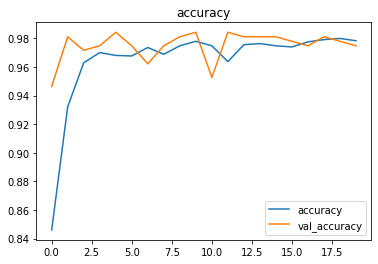

In [17]:
plot(history.history, "accuracy", "val_accuracy")

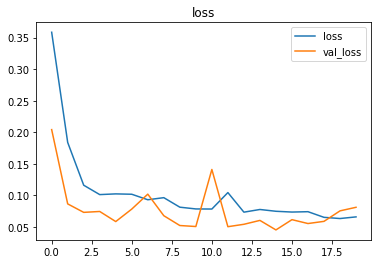

In [18]:
plot(history.history, "loss", "val_loss")

## Prediction

In [19]:
# Pick random test sample
i = random.randint(0, len(test_df)-1)

model_output = model.predict(Xtest[i].reshape(1, -1))[0]
pred = np.argmax(model_output)

# show predicted output
print ("\nModel predicted the gender: ", output_columns[pred])

# actual output
print("Actual gender: ", output_columns[np.argmax(ytest[i])], "with probability", model_output[pred])


Model predicted the gender:  female
Actual gender:  female with probability 0.99998915


## deepC

In [20]:
!deepCC voice_gender_recognition.h5

reading [keras model] from 'voice_gender_recognition.h5'
Saved 'voice_gender_recognition.onnx'
reading onnx model from file  voice_gender_recognition.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) dense_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_2's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  voice_gender_recognition_deepC/voice_gender_recognition.cpp
INFO (ONNX): model files are ready in dir voice_gender_recognition_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 voice_gender_recognition_deepC/voice_gender_recognition.cpp -o voice_gender_recognit

In [21]:
# Pick random test sample
i = random.randint(0, len(test_df)-1)

np.savetxt('sample.data', Xtest[i])

# run exe with input
!voice_gender_recognition_deepC/voice_gender_recognition.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_2.out')
print ("\nModel predicted the gender: ", output_columns[np.argmax(nn_out)])

# actual output
print("Actual gender: ", output_columns[np.argmax(ytest[i])])

reading file sample.data.
writing file dense_2.out.

Model predicted the emotion:  female
Actual emotion:  female
